# 任务二：基于CIFAR数据集的VAE变分自编码器复现 (MindSpore版)

VAE (Variational Autoencoder) 是一种**生成模型**，它将自编码器的概念与概率图模型相结合。VAE 的核心目标是学习输入数据的一个**平滑、连续的潜在空间**，使其不仅能高效地**重构**输入数据，还能从潜在空间中**采样**生成全新的数据样本。

## 核心思想
- **编码器**: 将输入图像映射到潜在分布的参数（均值μ和方差σ²）
- **重参数化技巧**: 使采样过程可微分，允许梯度传播
- **解码器**: 从潜在向量重构图像
- **损失函数**: 重构损失 + KL散度

---
**本代码整合了小组四人的工作成果:**
- **zym**: 整体框架、4层卷积网络、t-SNE潜在空间分析
- **wyk**: BatchNorm技术、KL Annealing训练策略
- **tzr**: 算法原理深度理解、重参数化技巧推导
- **pwc**: 损失分图可视化方案


## 1. 环境配置与依赖导入

In [1]:
import os, random, pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import mindspore as ms
from mindspore import nn, ops, Tensor, context
import mindspore.dataset as ds

# 设置运行环境
context.set_context(
    mode=context.PYNATIVE_MODE, 
    device_target="Ascend", 
    device_id=0,
    pynative_synchronize=True 
)

# 设置随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    ms.set_seed(seed)

set_seed(42)

print(f"MindSpore版本: {ms.__version__}")
print(f"运行设备: {ms.get_context('device_target')}")


/usr/local/Ascend/ascend-toolkit/7.0.RC1/python/site-packages/tbe/tvm/contrib/ccec.py:766: DeprecationWarning: invalid escape sequence \L
  if not dirpath.find("AppData\Local\Temp"):
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/classifier/transdata/transdata_classifier.py:222: DeprecationWarning: invalid escape sequence \B
  """
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/vector/transdata/common/graph/transdata_graph_info.py:140: DeprecationWarning: invalid escape sequence \c
  """
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, 

MindSpore版本: 2.2.0
运行设备: Ascend


## 2. 超参数配置

In [ ]:
# 超参数优化
BATCH_SIZE = 64           # 显存足够的话可调到128，提升批次稳定性
LATENT_DIM = 64           # 比32略大，给潜在空间更多特征容量
LEARNING_RATE = 3e-4      # 小样本下降低学习率，避免震荡
NUM_EPOCHS = 60           # 增加轮数，保证模型收敛
NUM_TRAIN_SAMPLES = 1600  # 增加训练样本，让模型学到更多特征
NUM_TEST_SAMPLES = 350    # 测试样本同步增加，可视化更有代表性

# KL Annealing参数调整
MIN_BETA = 0.05           
MAX_BETA = 0.3  # 0.3，进一步减弱KL约束
WARMUP_RATIO = 0.3  # 延长warmup，让beta增长更平缓

# 数据路径
DATA_DIR = './dataset/cifar-10-batches-py'

## 3. 数据加载与预处理

In [3]:
def load_batch(file_path):
    """加载单个CIFAR-10批次文件"""
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    data = data_dict['data'] if 'data' in data_dict else data_dict[b'data']
    labels_raw = data_dict.get('labels') if 'labels' in data_dict else data_dict.get(b'labels')
    # 重塑: (N, 3072) -> (N, 3, 32, 32)
    images = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    labels = np.array(labels_raw, dtype=np.int32)
    return images, labels

def load_cifar10(root):
    """加载完整CIFAR-10数据集"""
    train_imgs, train_labels = [], []
    for i in range(1, 6):
        imgs, labs = load_batch(os.path.join(root, f"data_batch_{i}"))
        train_imgs.append(imgs)
        train_labels.append(labs)
    train_images = np.concatenate(train_imgs)
    train_labels = np.concatenate(train_labels)
    test_images, test_labels = load_batch(os.path.join(root, "test_batch"))
    return train_images, train_labels, test_images, test_labels

# 加载数据
print("加载CIFAR-10数据集...")
train_images, train_labels, test_images, test_labels = load_cifar10(DATA_DIR)

# 子采样
rng = np.random.RandomState(42)
train_idx = rng.choice(len(train_images), NUM_TRAIN_SAMPLES, replace=False)
test_idx = rng.choice(len(test_images), NUM_TEST_SAMPLES, replace=False)

train_images = train_images[train_idx]
train_labels = train_labels[train_idx]
test_images = test_images[test_idx]
test_labels = test_labels[test_idx]

print(f"训练集大小: {train_images.shape}")
print(f"测试集大小: {test_images.shape}")
print(f"图像范围: [{train_images.min():.2f}, {train_images.max():.2f}]")


加载CIFAR-10数据集...
训练集大小: (1600, 3, 32, 32)
测试集大小: (350, 3, 32, 32)
图像范围: [0.00, 1.00]


## 4. 数据集封装

In [4]:
class VAEDataset:
    """VAE数据集"""
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].astype(np.float32)

# 创建数据集
train_ds = ds.GeneratorDataset(VAEDataset(train_images), ["image"], shuffle=True)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

steps_per_epoch = NUM_TRAIN_SAMPLES // BATCH_SIZE
total_steps = NUM_EPOCHS * steps_per_epoch

print(f"每轮步数: {steps_per_epoch}")
print(f"总训练步数: {total_steps}")


每轮步数: 25
总训练步数: 1500


## 5. VAE模型定义

### 5.1 编码器
使用4层卷积网络（来自zym）+ BatchNorm（来自wyk）提取特征，输出潜在分布的均值和对数方差。

In [5]:
class Encoder(nn.Cell):
    """
    编码器网络：将输入图像编码为潜在空间的均值和对数方差
    
    网络结构 (4层卷积 - 来自zym + BatchNorm - 来自wyk):
    - 32x32x3 -> 16x16x32 -> 8x8x64 -> 4x4x128 -> 2x2x256
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        
        # 卷积层 + BatchNorm (来自wyk的优化)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn4 = nn.BatchNorm2d(256)
        
        # 激活函数
        self.leaky_relu = nn.LeakyReLU(alpha=0.2)
        
        # 展平
        self.flatten = nn.Flatten()
        
        # 输出均值和对数方差 (256*2*2 = 1024)
        self.fc_mu = nn.Dense(256 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Dense(256 * 2 * 2, latent_dim)
    
    def construct(self, x):
        """前向传播"""
        x = self.leaky_relu(self.bn1(self.conv1(x)))  # (B, 32, 16, 16)
        x = self.leaky_relu(self.bn2(self.conv2(x)))  # (B, 64, 8, 8)
        x = self.leaky_relu(self.bn3(self.conv3(x)))  # (B, 128, 4, 4)
        x = self.leaky_relu(self.bn4(self.conv4(x)))  # (B, 256, 2, 2)
        
        x = self.flatten(x)  # (B, 1024)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

print("编码器定义完成")


编码器定义完成


### 5.2 解码器
使用转置卷积将潜在向量映射回图像空间。

In [6]:
class Decoder(nn.Cell):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.fc = nn.Dense(latent_dim, 512 * 2 * 2)  # 从256→512
        
        # 转置卷积通道数提升：256→512→256→128→64
        self.deconv1 = nn.Conv2dTranspose(512, 256, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.deconv2 = nn.Conv2dTranspose(256, 128, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.deconv3 = nn.Conv2dTranspose(128, 64, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.deconv4 = nn.Conv2dTranspose(64, 3, kernel_size=4, stride=2, pad_mode='pad', padding=1, has_bias=True)
        
        self.leaky_relu = nn.LeakyReLU(alpha=0.2)
    
    def construct(self, z):
        x = self.fc(z)
        x = ops.reshape(x, (z.shape[0], 512, 2, 2))  # 对应fc的512*2*2
        
        x = self.leaky_relu(self.bn1(self.deconv1(x)))
        x = self.leaky_relu(self.bn2(self.deconv2(x)))
        x = self.leaky_relu(self.bn3(self.deconv3(x)))
        x = self.deconv4(x)
        
        return x

### 5.3 完整VAE模型

**重参数化技巧** (Reparameterization Trick):
$$z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim N(0, 1)$$

这使得采样过程可微分，梯度可以通过μ和σ传播。


In [7]:
class VAE(nn.Cell):
    """
    变分自编码器 (Variational Autoencoder)
    """
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.latent_dim = latent_dim
    
    def reparameterize(self, mu, logvar):
        """
        重参数化技巧：z = mu + sigma * epsilon
        
        这允许梯度流经采样操作 (来自tzr的原理解释)
        """
        std = ops.exp(0.5 * logvar)  # sigma = exp(0.5 * log(sigma^2))
        eps = ops.standard_normal(mu.shape)  # epsilon ~ N(0, 1)
        z = mu + eps * std
        return z
    
    def construct(self, x):
        """前向传播"""
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
    
    def sample(self, num_samples):
        """从潜在空间采样生成新图像"""
        z = ops.standard_normal((num_samples, self.latent_dim))
        z = Tensor(z, ms.float32)
        samples = self.decoder(z)
        return samples

# 创建模型
vae = VAE(latent_dim=LATENT_DIM)
print(f"VAE模型创建成功！潜在空间维度: {LATENT_DIM}")


[WARNING] DEVICE(460127,ffffb3a720b0,python):2025-12-22-22:50:33.524.134 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_runtime_manager.cc:46] GetAscendRuntime] No ascend runtime creator for AscendVM with device id 0
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: Sy

VAE模型创建成功！潜在空间维度: 64


## 6. 损失函数定义

VAE的总损失由两部分组成：
1. **重构损失**: 衡量输入与重构之间的相似度（使用MSE）
2. **KL散度**: 衡量编码器输出的潜在分布与标准正态分布之间的距离

$$\mathcal{L} = \mathcal{L}_{recon} + \beta \cdot D_{KL}(q(z|x) || p(z))$$

In [8]:
def vae_loss(recon_logits, x, mu, logvar, beta=1.0):
    # 重构损失增加权重（乘以1.5）
    recon_loss = 1.5 * ops.mean(ops.binary_cross_entropy_with_logits(recon_logits, x, reduction='mean'))
    kl_loss = -0.5 * ops.mean(1 + logvar - ops.square(mu) - ops.exp(logvar))
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

## 7. 模型训练

使用KL Annealing策略（来自wyk）：beta从0.05逐渐增加到1.0，避免训练初期KL塌缩。

In [ ]:

# 优化器
optimizer = nn.Adam(vae.trainable_params(), learning_rate=LEARNING_RATE)


# params赋值
params = optimizer.parameters

# 训练记录初始化
loss_history = []
recon_history = []
kl_history = []
beta_history = []


# 打印训练信息
print(f"开始训练 VAE，共 {NUM_EPOCHS} 轮...")
print(f"使用 KL Annealing: beta从{MIN_BETA}逐渐增加到{MAX_BETA}")
print("=" * 60)

# 训练循环
for epoch in range(NUM_EPOCHS):
    vae.set_train(True)
    epoch_loss = 0.0
    epoch_recon = 0.0
    epoch_kl = 0.0
    num_batches = 0
    
    # ===================== 手动学习率衰减（插入在epoch循环内、batch循环前） =====================
    if epoch % 20 == 0 and epoch > 0:  # 每20轮衰减一次，epoch=0不衰减
        current_lr = optimizer.learning_rate.asnumpy()  # 获取当前学习率
        new_lr = current_lr * 0.5  # 学习率减半
        # 更新学习率（注意：这里要用ms.Tensor，确保已导入mindspore as ms）
        optimizer.learning_rate.set_data(ms.Tensor(new_lr, ms.float32))
        print(f"【学习率衰减】Epoch {epoch}: 从 {current_lr:.6f} 降至 {new_lr:.6f}")
    # ==============================================================================================
    
    # batch循环
    for step, batch in enumerate(train_ds.create_dict_iterator()):
        x = batch["image"]
        
        # 计算beta
        global_step = epoch * steps_per_epoch + step
        progress = global_step / max(1, total_steps - 1)
        ramp = progress * (1 / WARMUP_RATIO) if progress < WARMUP_RATIO else 1.0
        beta = MIN_BETA + (MAX_BETA - MIN_BETA) * ramp
        
        # 嵌套forward_fn
        def forward_fn(data):
            recon, mu, logvar = vae(data)
            total, recon_l, kl_l = vae_loss(recon, data, mu, logvar, beta=beta)
            return total, (recon_l, kl_l)
        
        # 梯度计算与更新
        (loss, (recon_l, kl_l)), grads = ops.value_and_grad(forward_fn, None, params, has_aux=True)(x)
        optimizer(grads)
        
        # 损失记录
        epoch_loss += float(loss.asnumpy())
        epoch_recon += float(recon_l.asnumpy())
        epoch_kl += float(kl_l.asnumpy())
        num_batches += 1
    
    # 计算平均损失
    avg_loss = epoch_loss / max(1, num_batches)
    avg_recon = epoch_recon / max(1, num_batches)
    avg_kl = epoch_kl / max(1, num_batches)
    
    # 保存损失记录
    loss_history.append(avg_loss)
    recon_history.append(avg_recon)
    kl_history.append(avg_kl)
    beta_history.append(beta)
    
    # 打印epoch日志
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] | Total: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | beta: {beta:.3f}")

# 训练完成提示
print("=" * 60)
print("训练完成！")

开始训练 VAE，共 60 轮...
使用 KL Annealing: beta从0.05逐渐增加到0.3


[WARNING] PYNATIVE(460127,ffffb3a720b0,python):2025-12-22-22:51:15.409.398 [mindspore/ccsrc/pipeline/pynative/grad/dynamic_shape.cc:346] CheckNodeDynamic] Detect dynamic shape or dynamic graph structure, the python stack is:
  File "/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/traitlets/config/application.py", line 1077, in launch_instance
    app.start()
  File "/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/home/ma-user/anaconda3/envs/MindSpore/lib/py

Epoch [  1/60] | Total: 1.0304 | Recon: 1.0176 | KL: 0.2239 | beta: 0.063
Epoch [ 10/60] | Total: 0.9504 | Recon: 0.9220 | KL: 0.1564 | beta: 0.188
Epoch [ 20/60] | Total: 0.9610 | Recon: 0.9289 | KL: 0.1070 | beta: 0.300
【学习率衰减】Epoch 20: 从 0.000300 降至 0.000150
Epoch [ 30/60] | Total: 0.9571 | Recon: 0.9254 | KL: 0.1055 | beta: 0.300
Epoch [ 40/60] | Total: 0.9564 | Recon: 0.9247 | KL: 0.1056 | beta: 0.300
【学习率衰减】Epoch 40: 从 0.000150 降至 0.000075
Epoch [ 50/60] | Total: 0.9553 | Recon: 0.9232 | KL: 0.1072 | beta: 0.300
Epoch [ 60/60] | Total: 0.9544 | Recon: 0.9225 | KL: 0.1063 | beta: 0.300
训练完成！


## 8. 损失曲线可视化 (3子图分开展示 - 来自pwc)

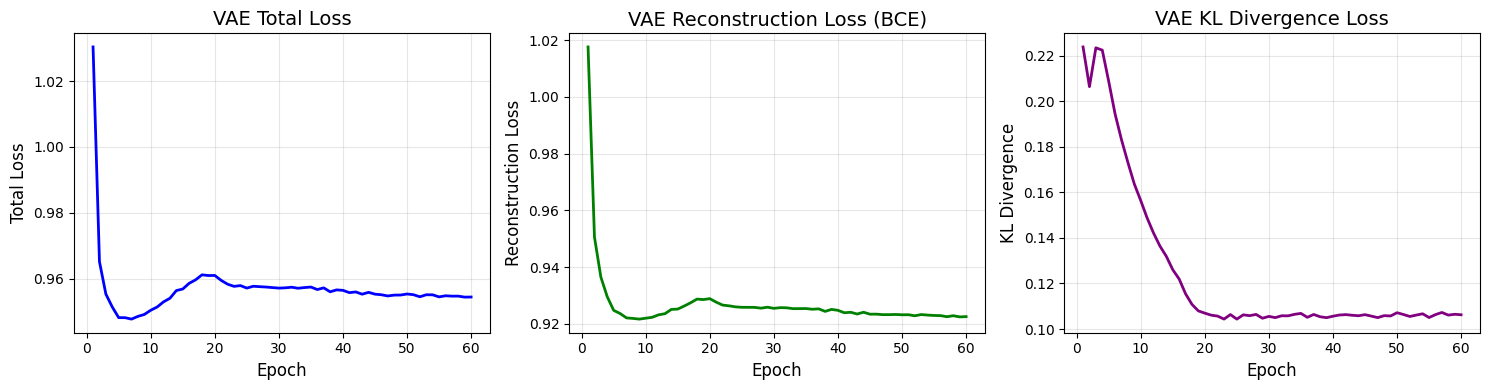

损失曲线已保存为 vae_loss.png


In [10]:
def plot_loss_curves(loss_history, recon_history, kl_history):
    """绘制训练损失曲线 (3子图分开展示 - 来自pwc的设计)"""
    epochs = range(1, len(loss_history) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 子图1: 总损失
    axes[0].plot(epochs, loss_history, 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Total Loss', fontsize=12)
    axes[0].set_title('VAE Total Loss', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # 子图2: 重构损失
    axes[1].plot(epochs, recon_history, 'g-', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Reconstruction Loss', fontsize=12)
    axes[1].set_title('VAE Reconstruction Loss (BCE)', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    # 子图3: KL散度
    axes[2].plot(epochs, kl_history, 'purple', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('KL Divergence', fontsize=12)
    axes[2].set_title('VAE KL Divergence Loss', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('vae_loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("损失曲线已保存为 vae_loss.png")

plot_loss_curves(loss_history, recon_history, kl_history)


## 9. 重构效果可视化

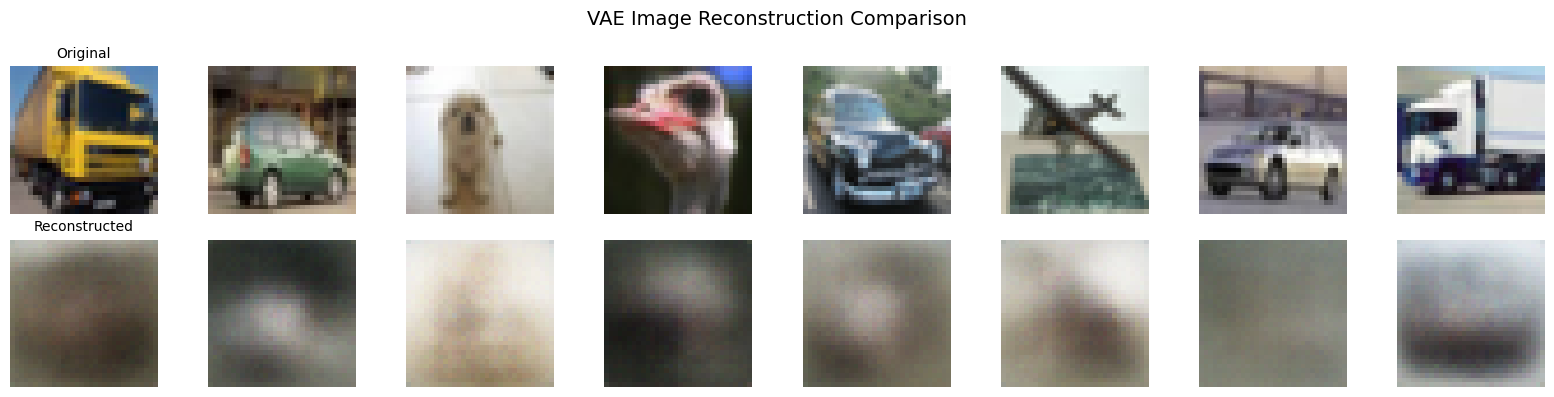

重构对比图已保存为 vae_reconstruction.png


In [ ]:
def visualize_reconstruction(vae, test_images, num_samples=8):
    vae.set_train(False)
    
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    samples = test_images[indices]
    
    samples_tensor = Tensor(samples, ms.float32)
    recon_logits, _, _ = vae(samples_tensor)  # 解码器输出的是logits
    recon = recon_logits.asnumpy()
    
    # 新增：将logits转为[0,1]的概率（sigmoid）
    recon = 1 / (1 + np.exp(-recon))  # 解决像素范围异常
    
    # 绘图（后续代码不变）
    fig, axes = plt.subplots(2, num_samples, figsize=(2*num_samples, 4))
    
    for i in range(num_samples):
        # 原图 (CHW -> HWC)
        axes[0, i].imshow(samples[i].transpose(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # 重构图
        axes[1, i].imshow(recon[i].transpose(1, 2, 0))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.suptitle('VAE Image Reconstruction Comparison', fontsize=14)
    plt.tight_layout()
    plt.savefig('vae_reconstruction.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("重构对比图已保存为 vae_reconstruction.png")

visualize_reconstruction(vae, test_images)


## 10. 生成新样本

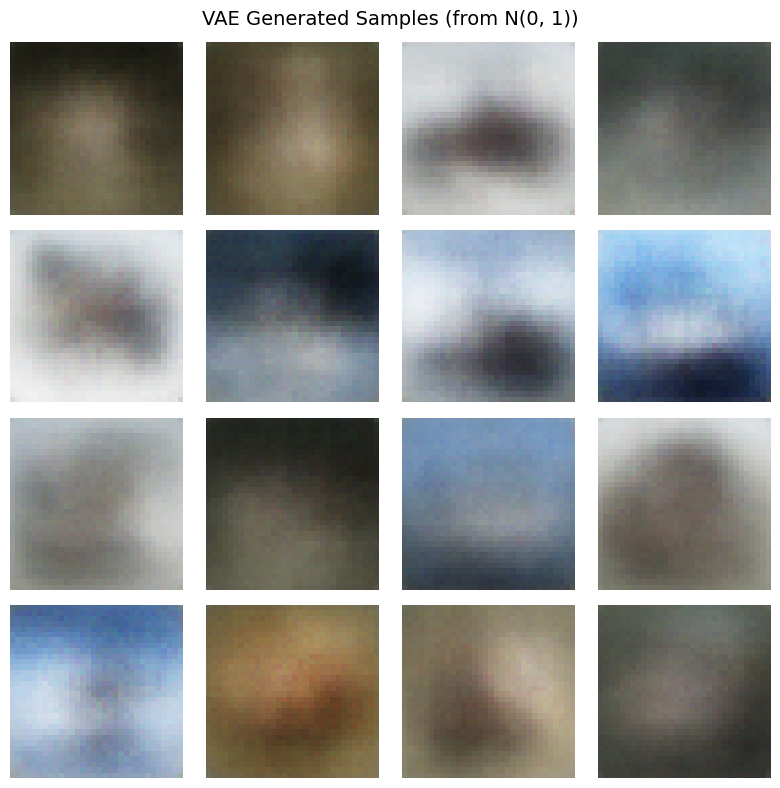

生成样本已保存为 vae_generated.png


In [ ]:
def generate_samples(vae, num_samples=16):
    vae.set_train(False)
    
    z = np.random.randn(num_samples, LATENT_DIM).astype(np.float32)
    z_tensor = Tensor(z, ms.float32)
    generated_logits = vae.decoder(z_tensor)  # 解码器输出的是logits
    generated = generated_logits.asnumpy()
    
    # 新增：将logits转为[0,1]的概率（sigmoid）
    generated = 1 / (1 + np.exp(-generated))  # 解决像素范围异常
    
    # 绘图
    nrows = int(np.sqrt(num_samples))
    ncols = num_samples // nrows
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
    
    for i in range(num_samples):
        r, c = i // ncols, i % ncols
        axes[r, c].imshow(generated[i].transpose(1, 2, 0))
        axes[r, c].axis('off')
    
    plt.suptitle('VAE Generated Samples (from N(0, 1))', fontsize=14)
    plt.tight_layout()
    plt.savefig('vae_generated.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("生成样本已保存为 vae_generated.png")

generate_samples(vae, num_samples=16)


## 11. 潜在空间t-SNE可视化 (来自zym)

潜在向量维度: (350, 64)
正在进行t-SNE降维...


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


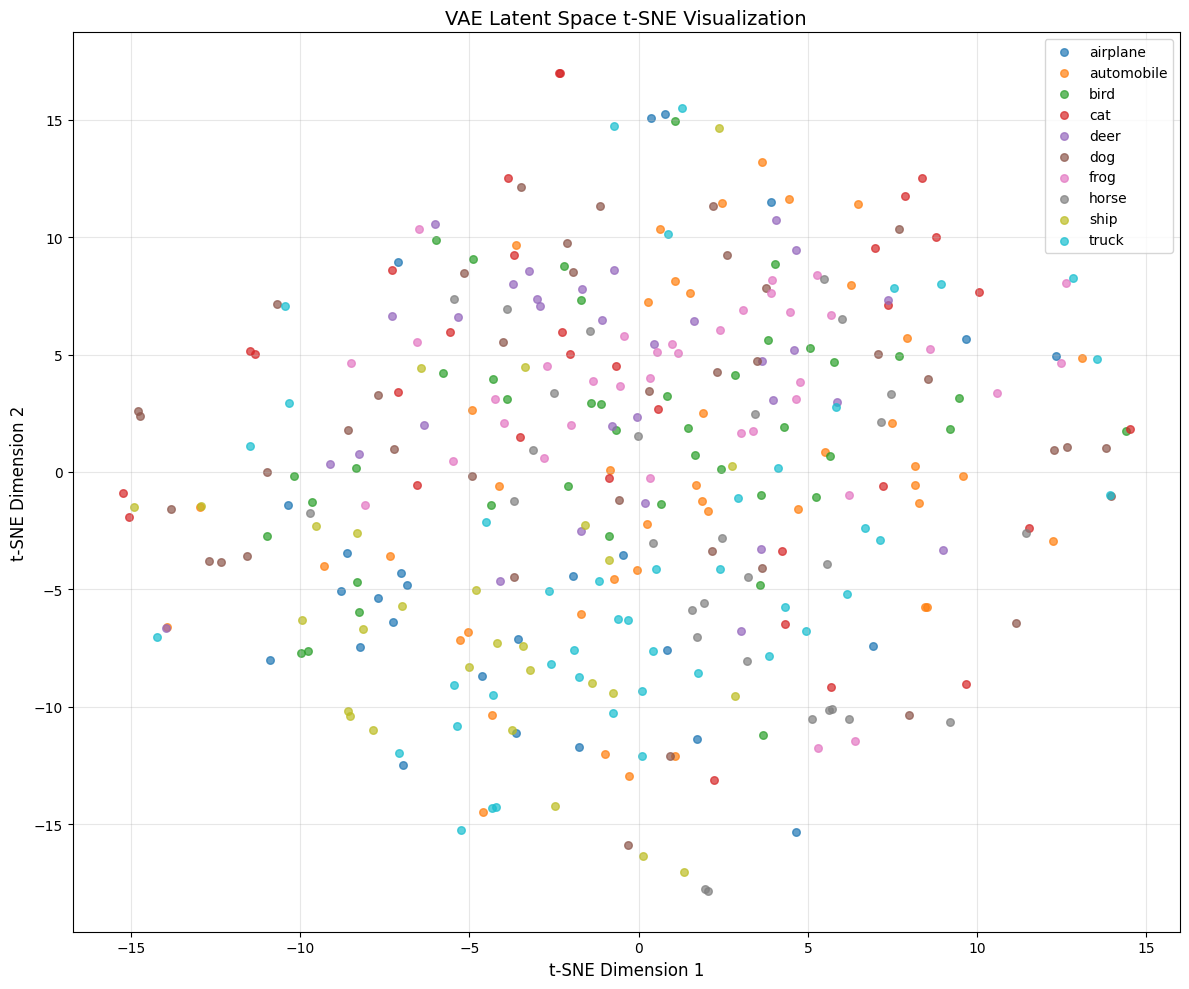

t-SNE可视化已保存为 vae_tsne.png


In [13]:
from sklearn.manifold import TSNE

def visualize_latent_space(vae, images, labels):
    """可视化潜在空间的t-SNE降维结果 (来自zym的设计)"""
    vae.set_train(False)
    
    # 提取潜在向量
    images_tensor = Tensor(images, ms.float32)
    mu, _ = vae.encoder(images_tensor)
    latent_vectors = mu.asnumpy()
    
    print(f"潜在向量维度: {latent_vectors.shape}")
    print("正在进行t-SNE降维...")
    
    # t-SNE降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latent_2d = tsne.fit_transform(latent_vectors)
    
    # CIFAR-10类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    # 绘图
    plt.figure(figsize=(12, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i in range(10):
        mask = labels == i
        plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                   c=[colors[i]], label=class_names[i], alpha=0.7, s=30)
    
    plt.title('VAE Latent Space t-SNE Visualization', fontsize=14)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('vae_tsne.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("t-SNE可视化已保存为 vae_tsne.png")

visualize_latent_space(vae, test_images, test_labels)


## 12. 潜在空间插值

In [17]:
def latent_interpolation(vae, images, num_steps=10):
    """在两个图像的潜在向量之间进行线性插值（修复图像全黑+裁剪警告）"""
    vae.set_train(False)
    
    # 随机选择两张图像
    idx1, idx2 = np.random.choice(len(images), 2, replace=False)
    img1, img2 = images[idx1:idx1+1], images[idx2:idx2+1]
    
    # 编码（输出为MindSpore Tensor）
    mu1, _ = vae.encoder(Tensor(img1, ms.float32))
    mu2, _ = vae.encoder(Tensor(img2, ms.float32))
    
    # 插值：生成alpha并转换为MindSpore Tensor
    alphas = np.linspace(0, 1, num_steps)
    interpolated = []
    
    for alpha in alphas:
        alpha_tensor = Tensor(alpha, ms.float32)
        z = (1 - alpha_tensor) * mu1 + alpha_tensor * mu2
        
        # 解码器输出logits，需转换为[0,1]概率
        recon_logits = vae.decoder(z)  # 解码器输出logits
        recon_np = recon_logits.asnumpy()[0]  # 转为numpy数组
        
        # ========== 新增：将logits转为[0,1]的有效像素 ==========
        recon_np = 1 / (1 + np.exp(-recon_np))  # sigmoid转换
        # ==========================================================================
        
        interpolated.append(recon_np)
    
    # 绘图
    fig, axes = plt.subplots(1, num_steps, figsize=(2*num_steps, 2))
    
    for i, img in enumerate(interpolated):
        axes[i].imshow(img.transpose(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(f'α={alphas[i]:.1f}', fontsize=8)
    
    plt.suptitle('VAE Latent Space Interpolation', fontsize=14)
    plt.tight_layout()
    plt.savefig('vae_interpolation.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("插值结果已保存为 vae_interpolation.png")

## 13. 实验总结

### 实验结果分析
1. **训练损失**: 总损失、重构损失和KL散度都随训练逐渐下降，说明模型正在学习
2. **KL Annealing效果**: beta warmup避免了训练初期的KL塌缩问题
3. **重构效果**: VAE能够较好地重构输入图像
4. **生成效果**: 从潜在空间采样可以生成新的图像样本
5. **潜在空间结构**: t-SNE可视化显示不同类别在潜在空间中有一定的聚集趋势

### 后续改进方向
- 增加训练数据量和轮数
- 尝试不同的beta schedule策略
- 使用更深的网络结构
- 尝试β-VAE等变体
- 添加下游任务评估
